#Introduction
Introduction to be modified

# Installs

In [2]:
%pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Imports
These are the libraries this notebook is going to use. if you're having difficulty with executing the notebook make sure to have all modules correctly installed in your enviroment.

In [3]:
import pandas as pd
import requests
from io import BytesIO
import numpy as np
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns

# Getting Started

In [21]:
data_url = "https://raw.githubusercontent.com/Abd-Elhakim-Arabet/TC-Analysis/main/attempt_20_01.xlsx"
response = requests.get(data_url, verify=False)
sheets_to_combine = ["Feuil1"]
data = pd.read_excel(BytesIO(response.content), sheet_name=sheets_to_combine, engine='openpyxl')
data = pd.concat(data.values(), ignore_index=True)
# Drop the ID column
data = data.drop(['ID'],axis=1)
print(f'Number of instances = {data.shape[0]}' )
print(f'Number of attributes = {data.shape[1]}' )
data.head()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Number of instances = 410
Number of attributes = 25


,N° DM 2023,Sexe,Age,wilaya,Type de CPT,Nombre de nodules,TNM,echographie,cytoponction,Diamètre,...,chirurgie,curage gg,suite post opératoires,métastases gg,Métastases à distance,prise Iode,invasion capsulaire,invasion tissu musculaire,emboles vasculaires,Unnamed: 26
0,001/23,F,43.0,jijel,classique,NaN,pT1b,TIRADS 4,NaN,NaN,...,TT,NaN,simples,non,non,NaN,oui,oui,non,NaN
1,002/23,F,53.0,alger,classique,1.0,pT1b,NaN,nodule,1.5 cm,...,TT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,003/23,F,48.0,alger,vésiculaire,2.0,NaN,NaN,NaN,10 mm,...,TT,NaN,simples,non,non,NaN,non,non,non,NaN
3,004/23,F,50.0,chlef,vésiculaire,1.0,pT2,NaN,NaN,1.4 cm,...,TT,NaN,simples,non,non,NaN,non,non,non,NaN
4,005/23,F,70.0,tipaza,classique,1.0,pT2N1b,TIRADS 4,nodule,2 cm,...,TT,central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Initial Transformation of the Data Types

Translating column names to english from french

In [5]:
#Translate french to english
def remove_accents(text):
    return ''.join(
        char for char in unicodedata.normalize('NFD', text)
        if unicodedata.category(char) != 'Mn'
    )

data.columns = [remove_accents(col) for col in data.columns]
data.columns = data.columns.str.strip()

Convert Diametre to a float number in cm

In [6]:
def convert_to_cm(value):
    if value is np.nan:
        return None
    if "cm" in value:
        return float(value.replace(" cm", "")) 
    elif "mm" in value:
        return float(value.replace(" mm", "")) / 10
    else:
        return None 
    
data["Diametre"] = data["Diametre"].apply(convert_to_cm)

In [7]:
data["Diametre"].dtype

dtype('float64')

# Handling Missing Values

In [31]:
count_na = (data.isna()).sum()

print("Empty Cells in each column")
print(count_na)


Empty Cells in each column
N° DM 2023                     0
Sexe                           1
Age                            7
wilaya                         8
Type de CPT                   11
Nombre de nodules            106
 TNM                          15
echographie                   89
cytoponction                  23
Diamètre                      32
Localisation                  29
Nombre de foyer              210
ATCD                          13
situation familiale            8
Unnamed: 16                   16
chirurgie                     18
curage gg                     40
suite post opératoires        61
métastases gg                 68
Métastases à distance         69
prise Iode                   175
invasion capsulaire           68
invasion tissu musculaire     68
emboles vasculaires           68
Unnamed: 26                  403
Age Group                      7
dtype: int64


Index(['N° DM 2023', 'Sexe', 'Age', 'wilaya', 'Type de CPT',
       'Nombre de nodules', ' TNM', 'echographie', 'cytoponction', 'Diamètre',
       'Localisation', 'Nombre de foyer', 'ATCD', 'situation familiale',
       'Unnamed: 16', 'chirurgie', 'curage gg', 'suite post opératoires',
       'métastases gg', 'Métastases à distance', 'prise Iode',
       'invasion capsulaire', 'invasion tissu musculaire',
       'emboles vasculaires', 'Unnamed: 26', 'Age Group'],
      dtype='object')

*Numeric Data:*

We will handle the missing numerical data by filling empty cells with the median value of that column 

In [9]:
data["Nombre de nodules"] = data["Nombre de nodules"].fillna(data["Nombre de nodules"].median())
data["Diametre"] = data["Diametre"].fillna(data["Diametre"].median())
data["Age"] = data["Age"].fillna(data["Age"].median())

*Categorical Data:*

To be handeled later, currently left as NaN

In [10]:
#To Do

# Outliers
Outliers are data instances with characteristics that are considerably different from the rest of the dataset. 

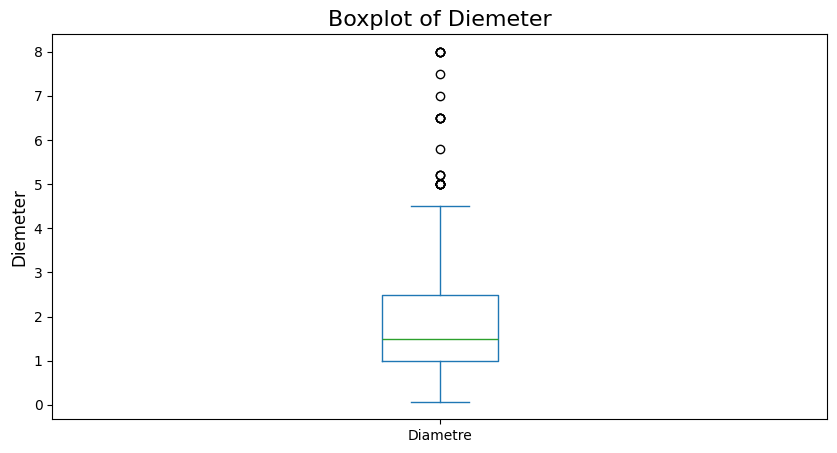

In [11]:
plt.figure(figsize=(10, 5))  
data['Diametre'].plot(kind='box', figsize=(10, 5))

plt.title("Boxplot of Diemeter", fontsize=16)
plt.ylabel("Diemeter", fontsize=12)

plt.show()

The boxplots suggest that only 8 instances have abnormally high Diemeter length. To discard the outliers, we can compute the Z-score and remove those instances containing a diameter with abnormally high or low Z-score (e.g., if Z > 3 or Z <= -3).

In [12]:
Z = (data['Diametre']-data['Diametre'].mean())/data['Diametre'].std()

In [13]:
print( f'Number of rows before discarding outliers = {data.__len__()}' )

data = data[(Z <= 3) & (Z >= -3)]
print( f'Number of rows after discarding outliers = {data.__len__()}' )

Number of rows before discarding outliers = 410
Number of rows after discarding outliers = 403


# Duplicates


In [14]:
dups = data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


With no duplicates in the data, no need to handle them

ALERT: WHEN MERGING THE ENTIRE SHEETS RECHECK FOR DUPLICATES

# Unify Values Names

In [15]:
data['echographie'].value_counts()

echographie
TIRADS 5     154
TIRADS 4      88
TIRADS 3      55
TIRADS 6       9
TIRADS 5       3
EUTIRAD5       2
TIRADS         2
EUTIRAD6       1
2              1
Name: count, dtype: int64

We drop the values 'TIRADS' and '2' because we can't be sure what they are reffering to

In [16]:
print( f'Number of rows before droping the values = {data.__len__()}' )

data = data[data['echographie'] != 'TIRADS ']
data = data[data['echographie'] != 2]
print( f'Number of rows after droping the values = {data.__len__()}' )

Number of rows before droping the values = 403
Number of rows after droping the values = 400


We gather the mistyped classes into one and make EUTIRAD into thier TIRADS counterpart

In [17]:
data['echographie'] = data['echographie'].replace(["TIRADS 5 ", "TIRADS 5", "EUTIRAD5"], "TIRADS 5")
data['echographie'] = data['echographie'].replace(["TIRADS 6 ", "EUTIRAD6"], "TIRADS 6")

# Visualize Correlation

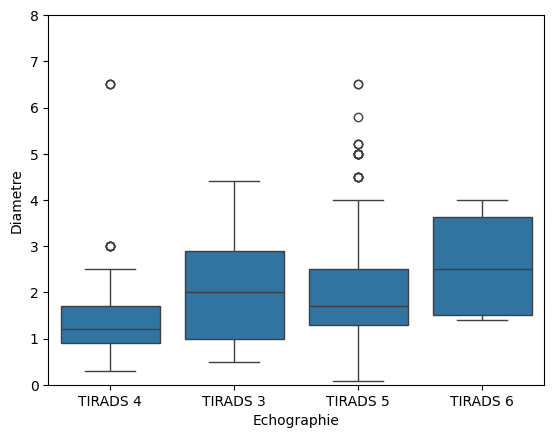

In [19]:
# Visualize relationship between price and room_type
sns.boxplot(x = 'echographie', y = 'Diametre', data = data)
plt.ylim(0, 8)
plt.xlabel('Echographie')
plt.ylabel('Diametre')
plt.show()

# Clustering